In [4]:
import sys
sys.path.insert(0, 'evoman')
from environment import Environment
from demo_controller import player_controller


import time
import numpy as np
import glob, os
import pandas as pd
import random
import matplotlib.pyplot as plt

### Initialize functions for evolution

In [3]:
def fitness(x):
    def play(y):
        fit, play, enem, time = env.play(pcont=y)
        return (fit, play, enem)
    return np.array(list(map(lambda z: play(z), x)))

In [4]:
def parentselect(pop_fitness,s):
    pop_frame = pd.DataFrame(pop_fitness,columns=['fitness']).reset_index()
    pop_sort = pop_frame.sort_values(axis=0,by='fitness')
    pop_sort = pop_sort.reset_index(drop=True).reset_index().rename(columns={'level_0':'rank','index':'pop_index','0':'fitness'})
    mu = len(pop_sort)
    rank = pop_sort['rank']
    p_parent = (2-s)/mu+2*rank*(s-1)/(mu*(mu-1))
    pop_sort['p_parent'] = p_parent
    parent_index = np.random.choice(pop_sort['pop_index'],1,p=pop_sort['p_parent'],replace=False)
    return parent_index

In [5]:
def create_offspring(pop,s):
    os_pop = np.zeros((0,nvar))
    for parent in range(0,pop.shape[0],2):
        parent1 = pop[parentselect(pop_fitness,s)]
        parent2 = pop[parentselect(pop_fitness,s)]
        n_os = np.random.randint(1,5,1)[0]
        os = np.zeros((n_os,nvar))
        for i in range(n_os):
            alpha = np.random.uniform(0,1)
            os[i] = alpha*parent1 + (1-alpha)*parent2
            for j in range(len(os[i])):
                if np.random.uniform(0,1) <= p_mutate:
                    os[i][j] = os[i][j] + np.random.normal(0,1)
                #if os[i][j] < llimit:
                #    os[i][j] = llimit
                #if os[i][j] > ulimit:
                #    os[i][j] = ulimit
            os_pop = np.vstack((os_pop, os[i]))
    return os_pop

In [6]:
def create_offspring_mult(pop,s,nparent=3):
    os_pop = np.zeros((0,nvar))
    for parent in range(0,pop.shape[0],nparent):
        #parents = {}
        #for p in range(1, nparent+1):
         #   parents["parent{0}".format(p)] = pop[parentselect(pop_fitness,s)]
        n_os = np.random.randint(1,5,1)[0]
        os = np.zeros((n_os,nvar))
        for i in range(n_os):
            weights = np.random.randint(1,10,nparent)
            weights = weights/sum(weights)
            for p in range(1,nparent+1):
                os[i] = os[i] + weights[p-1]*pop[parentselect(pop_fitness,s)]
            for j in range(len(os[i])):
                if np.random.uniform(0,1) <= p_mutate:
                    os[i][j] = os[i][j] + np.random.normal(0,1)
                if os[i][j] < llimit:
                    os[i][j] = llimit
                if os[i][j] > ulimit:
                    os[i][j] = ulimit
            os_pop = np.vstack((os_pop, os[i]))
    return os_pop

In [7]:
def roundrobin(pop,q,best=True):
    pop_wins = pd.DataFrame(pop_fitness,columns=['fitness']).reset_index()
    pop_wins['wins'] = np.zeros(len(pop_fitness))
    for i in range(len(pop_wins)):
        opps = random.sample(range(0,len(pop_wins)),q)
        while i in opps:
            opps[opps.index(i)] = random.sample(range(0,len(pop_wins)),1)[0]
        for j in opps:
            if pop_wins.loc[i,'fitness'] > pop_wins.loc[j,'fitness']:
                pop_wins.loc[i,'wins'] += 1
    pop_wins.sort_values(by='wins',inplace=True,ascending=False)
    pop_wins = pop_wins.reset_index(drop=True)

    return pop_wins.loc[0:npop-1,'index']

In [8]:
def sweep(pop,pop_fitness,drop=0.2):
    pop_sweep = pd.DataFrame(pop_fitness,columns=['fitness']).reset_index().sort_values(by='fitness',ascending=False).reset_index(drop=True)
    drop_index = round(len(pop_sweep)*(1-drop))
    pop_sweep = pop_sweep[0:drop_index]
    repl_length = (len(pop)-drop_index,nvar)
    repl = np.random.uniform(llimit, ulimit, repl_length)
    repl_eval = fitness(repl)
    repl_fitness = list(map(lambda z: z[0], repl_eval))
    pop = pop[np.array(pop_sweep['index'])]
    pop = np.vstack((pop,repl))
    pop_fitness = np.array(pop_fitness)[np.array(pop_sweep['index'])]
    pop_fitness = np.append(pop_fitness,repl_fitness)
    return pop, pop_fitness

### Run evolution for two- and multi-parent EA
Edit variable "enemy" for other enemies. 

In [8]:
multilist = [False, True]
for m in multilist:
    multi = m
    enemy = 3
    if not multi:
        experiment = 'double_enemy'+str(enemy)
    elif multi:
        experiment = 'multi_enemy'+str(enemy)
    if not os.path.exists(experiment):
        os.makedirs(experiment)

    #initialize environment
    reps = 10
    nnode = 10
    env = Environment(experiment_name=experiment,
                      enemies=[enemy],
                      playermode="ai",
                      player_controller=player_controller(nnode),
                      enemymode="static",
                      level=2,
                      speed="fastest",
                    logs ='off')
    
    #initialize parameters
    nvar = (env.get_num_sensors()+1)*nnode + (nnode+1)*5
    ulimit = 1
    llimit = -1
    npop=50
    popsize = (npop, nvar)
    gen=20
    p_mutate = 0.2

    #best_IG_updated = -200
    #best_individual = np.zeros((0,nvar))
    best_IG_total = np.zeros((0,0))
    best_ind_total = pd.DataFrame()
    for r in range(reps):#initialize population
        start = time.time()
        pop = np.random.uniform(llimit, ulimit, popsize)
        evaluation = fitness(pop)
        pop_fitness = list(map(lambda z: z[0], evaluation))
        pop_life = list(map(lambda z: z[1], evaluation))
        pop_enem = list(map(lambda z: z[2], evaluation))
        total_fitness = pd.DataFrame(pop_fitness).T
        total_life = pd.DataFrame(pop_life).T
        total_enem = pd.DataFrame(pop_enem).T
        best_fit, avg_fit, std_fit = np.array(pop_fitness[np.argmax(pop_fitness)]), np.array(np.mean(pop_fitness)), np.array(np.std(pop_fitness))
        unimproved = 0
        for i in range(gen):
            print( '\nGeneration: '+str(r)+'.'+str(i))
            print('calculating pop_fit')

            #create offspring and evaluate
            if multi:
                offspring = create_offspring_mult(pop,1.5,4)
            else:
                offspring = create_offspring(pop,1.5)
            print('calculating os_fit')
            os_evaluation = fitness(offspring)
            os_fitness = list(map(lambda z: z[0], os_evaluation))
            #stack parents and offspring (and their fitness)
            pop = np.vstack((pop,offspring))
            pop_fitness = np.append(pop_fitness,os_fitness)
            #round robin to determine survivors
            index = roundrobin(pop,10)
            pop = pop[index]
            evaluation = fitness(pop)
            pop_fitness = list(map(lambda z: z[0], evaluation))
            pop_life = np.array(list(map(lambda z: z[1], evaluation)))
            pop_enem = np.array(list(map(lambda z: z[2], evaluation)))
            pop_IG = pop_life-pop_enem
            #append information on generations
            total_fitness = total_fitness.append(pd.Series(pop_fitness),ignore_index=True)
            total_life = total_life.append(pd.Series(pop_life),ignore_index=True)
            total_enem = total_enem.append(pd.Series(pop_enem),ignore_index=True)
            best_IG = pop_IG[np.argmax(pop_IG)]
            best_ind = pop[np.argmax(pop_IG)]
            best_fit = np.append(best_fit,pop_fitness[np.argmax(pop_fitness)])
            avg_fit = np.append(avg_fit,np.mean(pop_fitness))
            std_fit = np.append(std_fit,np.std(pop_fitness))
            #sweep population when unimproved for 5 times
            if best_fit[i] <= best_fit[i-1]:
                unimproved += 1
            elif best_fit[i] > best_fit[i-1]+1:
                unimproved = 0
            if unimproved > 5:
                pop, pop_fitness = sweep(pop,pop_fitness,0.3)
                unimproved = 0
            print(str(unimproved)+' unimproved steps')
            print( '\nBest fitness: '+str(round(best_fit[i],2))+'\tAvg fitness: '+str(round(avg_fit[i],2)))
        #if best_IG > best_IG_updated:
            #best_individual = best_ind
            #best_IG_updated = best_IG
        best_IG_total = pd.DataFrame(np.append(best_IG_total,best_IG))
        best_ind_total = best_ind_total.append(pd.Series(best_ind),ignore_index=True)


        #save accumulated data
        fitness_data = pd.DataFrame({'Best fitness':best_fit,'Avg fitness':avg_fit,'Std fitness':std_fit})
        if not os.path.exists(experiment+'/rep'+str(r)):
            os.makedirs(experiment+'/rep'+str(r))
        fitness_data.to_csv(experiment+'/rep'+str(r)+'/fitstats.csv',index=True)
        total_fitness.to_csv(experiment+'/rep'+str(r)+'/fitness.csv',index=True)
        total_IG = total_life-total_enem
        total_IG.to_csv(experiment+'/rep'+str(r)+'/IG.csv',index=True)

        end = time.time()
        print('\nExcecution time: '+str(round(end-start))+' seconds')
    best_IG_total.to_csv(experiment+'/best_IGs.csv',index=True)
    best_ind_total.to_csv(experiment+'/best_indivs.csv',index=True)
 



Generation: 0.0
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 65.86	Avg fitness: 0.18

Generation: 0.1
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 65.86	Avg fitness: 7.3

Generation: 0.2
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 74.86	Avg fitness: 17.16

Generation: 0.3
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 74.86	Avg fitness: 25.69

Generation: 0.4
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 74.86	Avg fitness: 35.17

Generation: 0.5
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 88.1	Avg fitness: 47.2

Generation: 0.6
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 88.1	Avg fitness: 53.17

Generation: 0.7
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 88.1	Avg fitness: 57.82

Generation: 0.8
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitnes

2 unimproved steps

Best fitness: 87.39	Avg fitness: 61.0

Generation: 3.11
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 87.39	Avg fitness: 67.48

Generation: 3.12
calculating pop_fit
calculating os_fit
4 unimproved steps

Best fitness: 87.39	Avg fitness: 71.1

Generation: 3.13
calculating pop_fit
calculating os_fit
5 unimproved steps

Best fitness: 87.39	Avg fitness: 73.6

Generation: 3.14
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 87.39	Avg fitness: 76.87

Generation: 3.15
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 87.39	Avg fitness: 80.72

Generation: 3.16
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 87.39	Avg fitness: 79.42

Generation: 3.17
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 87.47	Avg fitness: 83.93

Generation: 3.18
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 87.47	Avg fitness: 84.55

Generation: 3.1

1 unimproved steps

Best fitness: 56.77	Avg fitness: -0.93

Generation: 7.1
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 74.77	Avg fitness: 10.14

Generation: 7.2
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 85.84	Avg fitness: 23.42

Generation: 7.3
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 85.84	Avg fitness: 32.3

Generation: 7.4
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 86.99	Avg fitness: 43.02

Generation: 7.5
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 86.99	Avg fitness: 50.17

Generation: 7.6
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 86.99	Avg fitness: 57.1

Generation: 7.7
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 87.91	Avg fitness: 60.94

Generation: 7.8
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 87.91	Avg fitness: 63.15

Generation: 7.9
calcul

calculating os_fit
0 unimproved steps

Best fitness: 91.79	Avg fitness: 55.19

Generation: 0.12
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 91.79	Avg fitness: 56.1

Generation: 0.13
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 91.79	Avg fitness: 56.82

Generation: 0.14
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 91.79	Avg fitness: 60.85

Generation: 0.15
calculating pop_fit
calculating os_fit
4 unimproved steps

Best fitness: 91.79	Avg fitness: 59.44

Generation: 0.16
calculating pop_fit
calculating os_fit
5 unimproved steps

Best fitness: 91.79	Avg fitness: 60.85

Generation: 0.17
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 91.79	Avg fitness: 56.0

Generation: 0.18
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 91.79	Avg fitness: 59.24

Generation: 0.19
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 91.79	Avg fitness: 56

calculating os_fit
2 unimproved steps

Best fitness: 85.24	Avg fitness: 10.44

Generation: 4.2
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 85.24	Avg fitness: 16.11

Generation: 4.3
calculating pop_fit
calculating os_fit
4 unimproved steps

Best fitness: 85.24	Avg fitness: 25.71

Generation: 4.4
calculating pop_fit
calculating os_fit
5 unimproved steps

Best fitness: 85.24	Avg fitness: 34.89

Generation: 4.5
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 87.01	Avg fitness: 45.18

Generation: 4.6
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 87.01	Avg fitness: 50.69

Generation: 4.7
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 87.01	Avg fitness: 55.67

Generation: 4.8
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 87.01	Avg fitness: 56.62

Generation: 4.9
calculating pop_fit
calculating os_fit
4 unimproved steps

Best fitness: 87.01	Avg fitness: 60.01

G

calculating os_fit
3 unimproved steps

Best fitness: 88.42	Avg fitness: 57.05

Generation: 7.13
calculating pop_fit
calculating os_fit
4 unimproved steps

Best fitness: 88.42	Avg fitness: 58.12

Generation: 7.14
calculating pop_fit
calculating os_fit
5 unimproved steps

Best fitness: 88.42	Avg fitness: 58.82

Generation: 7.15
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 88.42	Avg fitness: 60.24

Generation: 7.16
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 88.42	Avg fitness: 60.5

Generation: 7.17
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 88.42	Avg fitness: 51.81

Generation: 7.18
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 88.42	Avg fitness: 58.73

Generation: 7.19
calculating pop_fit
calculating os_fit
4 unimproved steps

Best fitness: 88.42	Avg fitness: 59.8

Excecution time: 1434 seconds

Generation: 8.0
calculating pop_fit
calculating os_fit
1 unimproved steps

Best 

#### Run every best individual 5 times, do this for double and multi

In [2]:
namelist = ['double1','multi1','double3','multi3','double5','multi5']
best_IG_data = pd.DataFrame()
for name_index in range(len(namelist)):
    enemy = namelist[name_index][-1]
    parents = namelist[name_index][0:-1]
    file = parents+str(enemy)
    best_indivs = pd.read_csv('Data/best_indivs_'+file+'.csv',index_col=0)

    nnode = 10
    env = Environment(experiment_name=parents,
                          enemies=[enemy],
                          playermode="ai",
                          player_controller=player_controller(nnode),
                          enemymode="static",
                          level=2,
                          speed="fastest",
                        logs ='off')
    best_IGs = np.zeros((10))
    for i in range(10):
        for j in range(5):
            fit, play, enem, time = env.play(pcont=np.array(best_indivs.iloc[i,]))
            IG = play-enem
            best_IGs[i] += IG/5
    best_IG_data[namelist[name_index]] = best_IGs
best_IG_data.to_csv('total_IG_data.csv')



TypeError: cannot unpack non-iterable NoneType object

#### Boxplot

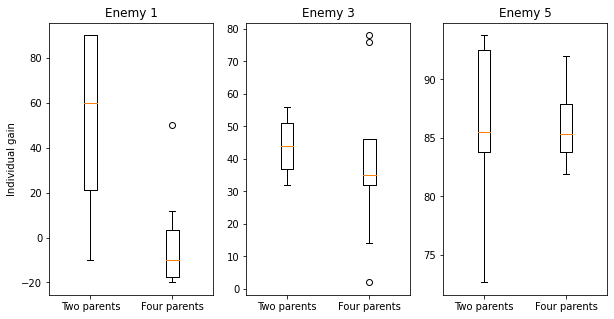

In [6]:
best_IG = pd.read_csv('Data/total_IG_data.csv', index_col=0)
best_IG.columns = ['double enemy1','multi enemy1','double enemy3','multi enemy3','double enemy5', 'multi enemy5']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
labels = ['Two parents', 'Four parents']
ax1.boxplot([best_IG['double enemy1'],best_IG['multi enemy1']], labels=labels) 
ax2.boxplot([best_IG['double enemy3'],best_IG['multi enemy3']], labels=labels) 
ax3.boxplot([best_IG['double enemy5'],best_IG['multi enemy5']], labels=labels) 
ax1.set(ylabel = 'Individual gain') 
ax1.set(title = 'Enemy 1')
ax2.set(title = 'Enemy 3')
ax3.set(title = 'Enemy 5')

plt.savefig('Boxplot_IG.png')

#### Lineplots 

Lineplot code is in separate file lineplot_total.